In [1]:
source("../../utils.R")
library(Seurat)

Attaching SeuratObject

‘SeuratObject’ was built under R 4.3.3 but the current version is
4.4.0; it is recomended that you reinstall ‘SeuratObject’ as the ABI
for R may have changed

Seurat v4 was just loaded with SeuratObject v5; disabling v5 assays and
validation routines, and ensuring assays work in strict v3/v4
compatibility mode


Attaching package: ‘Seurat’


The following object is masked from ‘package:base’:

    %||%




In [15]:
sobj <- readRDS("../../silhouette_real_life_examples/Atlas2_ArchR_tiles_ndim15.RDS")

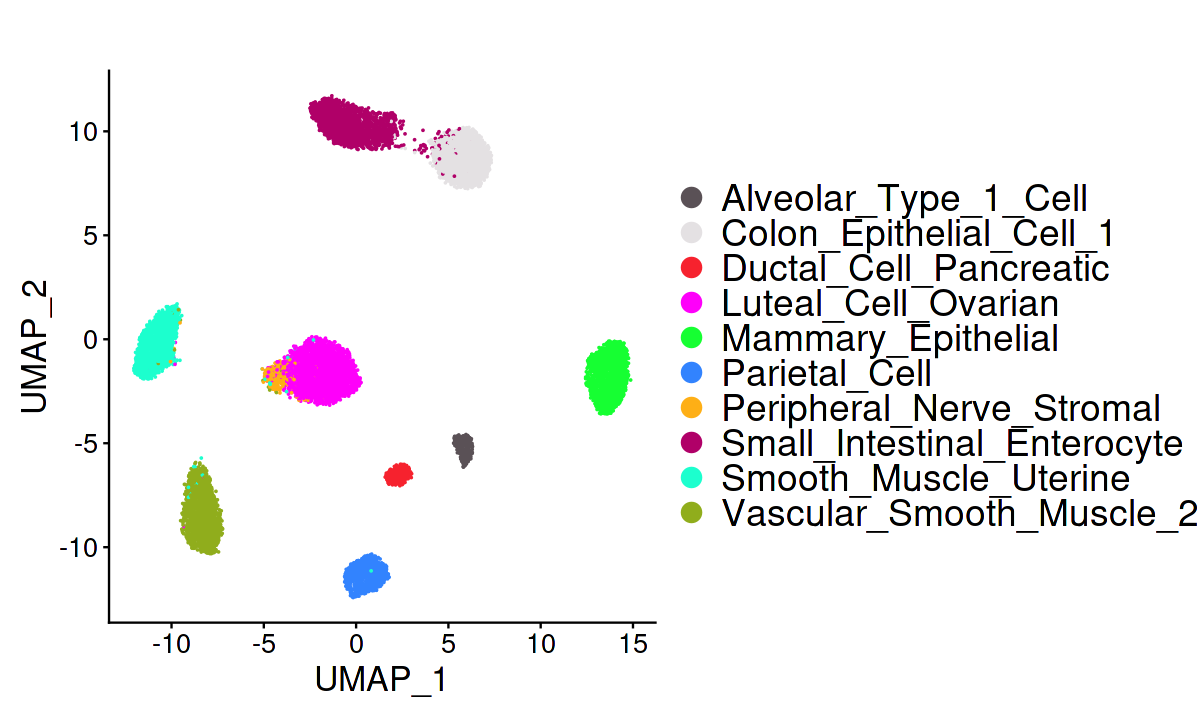

In [56]:
options(repr.plot.width=10, repr.plot.height=6)
p1 <- DimPlot(sobj, reduction = "umap", label = F, repel=T, 
    group.by = "ground_truth", cols="polychrome", pt.size=0.001)  +
    theme(plot.title = element_text(face = "bold", size=24), 
        text=element_text(size=20), 
        legend.text = element_text(size = 22),
        axis.text = element_text(size = 16)) + ggtitle("") +
guides(color = guide_legend(override.aes = list(size = 5)))

p1

In [19]:
embed <- sobj@reductions[["learned_embedding"]]@cell.embeddings

In [20]:
dist.euclidean <- cal_distance(embed, metric="Euclidean")
res_euclidean <- silhouette_result(dist.euclidean, sobj$ground_truth)

In [22]:
dist.cosine <- cal_distance(embed, metric="cosine")
res_cosine <- silhouette_result(dist.cosine, sobj$ground_truth)

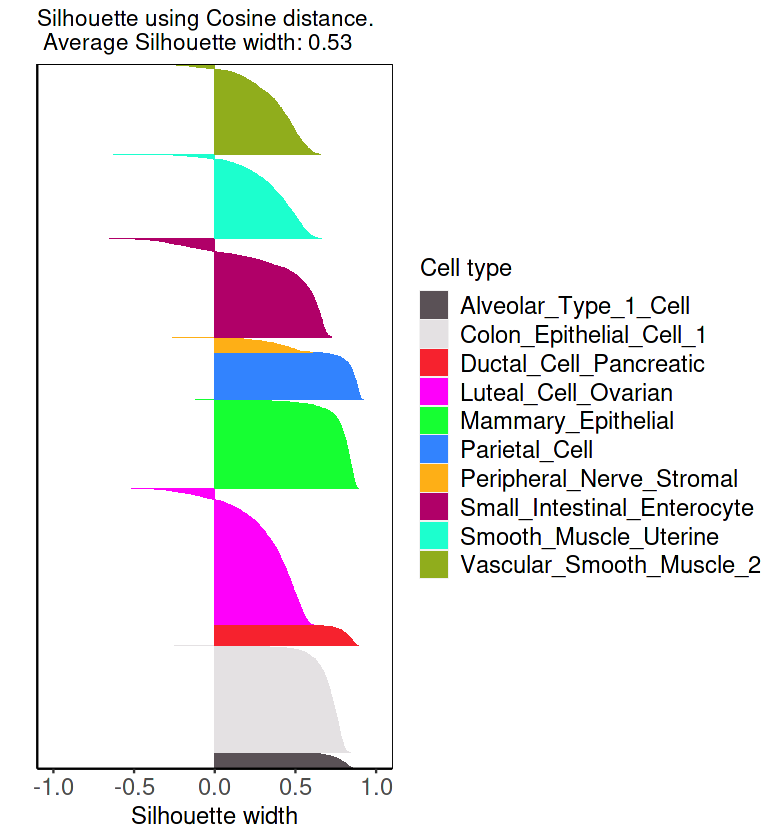

In [66]:
options(repr.plot.width=6.5, repr.plot.height=7)
df_res <- as.data.frame(res_cosine$sil)
df_res$labels <- as.factor(sobj$ground_truth)
df_res <- df_res[order(df_res[,"cluster"], -df_res$sil_width), ]
df_res$name <- as.factor(1:nrow(df_res))
df_res$cluster <- as.factor(df_res$cluster)

p2 <- ggplot(df_res, aes(x=sil_width, y=name, fill=labels)) + 
    geom_bar(stat = "identity") +
    labs(x = "Silhouette width", y = "",
         fill = "Cell type",
         title = paste0("Silhouette using Cosine distance.",
                        "\n Average Silhouette width: ", 
                        round(mean(df_res$sil_width), 2))) + 
    # theme_bw() +
    theme(axis.text.y = element_blank(), 
          axis.ticks.y = element_blank(),
          panel.background = element_blank(),
          panel.grid.major = element_blank(), 
          panel.grid.minor = element_blank(),
          axis.line = element_line(colour = "black"),
          panel.border = element_rect(colour = "black", fill=NA, size=0.2),
          axis.text.x = element_text(size = 14),  
          axis.title.x = element_text(size = 14),  
          legend.text = element_text(size = 14),  
          legend.title = element_text(size = 14)) +
    scale_fill_manual(values = my_col_polychrome) +
    scale_color_manual(values = my_col_polychrome) +
    xlim(-1,1)
p2                  

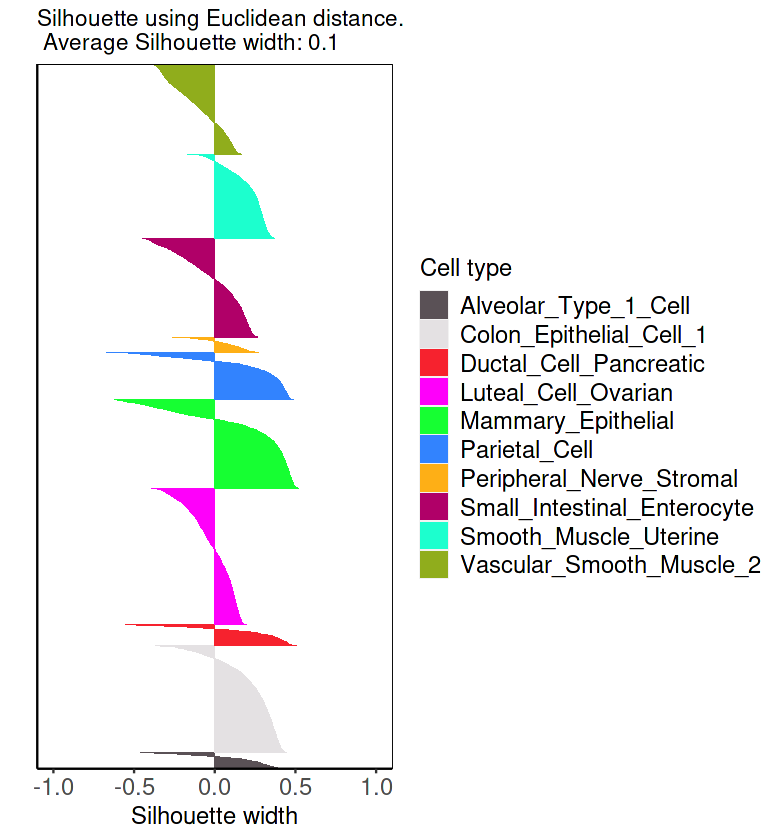

In [67]:
options(repr.plot.width=6.5, repr.plot.height=7)
df_res <- as.data.frame(res_euclidean$sil)
df_res$labels <- as.factor(sobj$ground_truth)
df_res <- df_res[order(df_res[,"cluster"], -df_res$sil_width), ]
df_res$name <- as.factor(1:nrow(df_res))
df_res$cluster <- as.factor(df_res$cluster)

p3 <- ggplot(df_res, aes(x=sil_width, y=name, fill=labels)) + 
    geom_bar(stat = "identity") +
    labs(x = "Silhouette width", y = "",
         fill = "Cell type",
         title = paste0("Silhouette using Euclidean distance.",
                        "\n Average Silhouette width: ", 
                        round(mean(df_res$sil_width), 2))) + 
    # theme_bw() +
    theme(axis.text.y = element_blank(), 
          axis.ticks.y = element_blank(),
          panel.background = element_blank(),
          panel.grid.major = element_blank(), 
          panel.grid.minor = element_blank(),
          axis.line = element_line(colour = "black"),
          panel.border = element_rect(colour = "black", fill=NA, size=0.2),
          axis.text.x = element_text(size = 14),  
          axis.title.x = element_text(size = 14),  
          legend.text = element_text(size = 14),  
          legend.title = element_text(size = 14)) +
    scale_fill_manual(values = my_col_polychrome) +
    scale_color_manual(values = my_col_polychrome) +
    xlim(-1,1)
p3                  

In [57]:
pdf("ArchR_tiles_Atlas2_UMAP.pdf", width=10, height=6)
plot(p1)
dev.off() 

png 
  2

In [68]:
pdf("ArchR_tiles_Atlas2_Silhouette_cosine.pdf", width=6.5, height=7)
plot(p2)
dev.off() 

png 
  2

In [69]:
pdf("ArchR_tiles_Atlas2_Silhouette_euclidean.pdf", width=6.5, height=7)
plot(p3)
dev.off() 

png 
  2

# Swiss row example

- http://www.sthda.com/english/wiki/impressive-package-for-3d-and-4d-graph-r-software-and-data-visualization
- https://jlmelville.github.io/smallvis/swisssne.html

In [ ]:
devtools::install_github("jlmelville/smallvis", subdir = "smallvis")
remotes::install_github("jlmelville/snedata")

In [70]:
library("plot3D")
library("snedata")


Attaching package: ‘snedata’


The following object is masked from ‘package:igraph’:

    random_walk




In [83]:
# Map a vector x to a new linear scale in the range (from, to)
linear_map <- function(x, from = 0, to = 1) {
  (x - min(x)) / max(x - min(x)) * (to - from) + from
}

# Helper function needed by hsl_to_rgb, from the CSS spec
# https://www.w3.org/TR/2011/REC-css3-color-20110607/#hsl-color
hue_to_rgb <- function(m1, m2, h) {
  if (h < 0) h <- h + 1
  if (h > 1) h <- h - 1
  if (h * 6 < 1) {
    return(m1 + (m2 - m1) * h * 6)
  }
  if (h * 2 < 1) {
    return(m2)
  }
  if (h * 3 < 2) {
    return(m1 + (m2 - m1) * (2 / 3 - h) * 6)
  }
  m1
}

# Linearly maps a numeric vector x onto a color scale ranging from
# hsl(0, s, l) to hsl(300, s, l) (basically a rainbow color scale).
linear_color_map <- function(x, h = 300, s = 50, l = 50) {
  vapply(
    linear_map(x, from = 0, to = 1),
    function(e) {
      hsl_to_rgb(h = floor(h * e), s = s, l = l)
    }, ""
  )
}

# Converts HSL to RGB, using the algorithm specified by the CSS spec
# https://www.w3.org/TR/2011/REC-css3-color-20110607/#hsl-color
# h is the hue in degrees in the range (0, 360] (i.e. 360 is excluded).
# s is the saturation as % in the range (0, 100)
# l is the luminance as % in the range (0, 100).
# Returns an RGB string.
hsl_to_rgb <- function(h, s, l) {
  # Map degrees to range (0, 360)
  h <- (((h %% 360) + 360) %% 360) / 360
  s <- s / 100
  l <- l / 100

  if (s == 0) {
    # achromatic
    r <- g <- b <- l
  } else {
    if (l <= 0.5) {
      m2 <- l * (s + 1)
    } else {
      m2 <- l + s - l * s
    }
    m1 <- l * 2 - m2
    r <- hue_to_rgb(m1, m2, h + 1 / 3)
    g <- hue_to_rgb(m1, m2, h)
    b <- hue_to_rgb(m1, m2, h - 1 / 3)
  }
  grDevices::rgb(red = r, green = g, blue = b)
}

swiss_roll <- function(n = 1000, min_phi = 1.5 * pi, max_phi = 4.5 * pi,
                       max_z = 10) {
  phi <- stats::runif(n, min = min_phi, max = max_phi)
  x <- phi * cos(phi)
  y <- phi * sin(phi)
  z <- stats::runif(n, max = max_z)

  data.frame(x, y, z, color = linear_color_map(phi), stringsAsFactors = FALSE, phi=phi)
}

In [84]:
sr3k_30 <- swiss_roll(n = 3000, max_z = 30)

In [85]:
head(sr3k_30)

,x,y,z,color,phi
,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,2.922242,6.854003,24.603244,#86BF40,7.450963
2,12.094936,4.563294,16.987119,#6C40BF,12.927147
3,11.590498,-3.932047,13.489746,#4042BF,12.239307
4,3.431830,6.521758,8.647891,#8CBF40,7.369585
5,6.206116,-9.755400,3.631125,#406FBF,11.562167
6,-6.415677,5.854089,19.130982,#40BF4D,8.685118


0.0905665,0.00000000,0.00000000,0.00000000
0.0000000,-0.06879694,-0.03971993,0.03971993
0.0000000,0.03334757,-0.05775969,0.05775969
-0.1416750,-0.39360334,-1.80445323,2.80445323


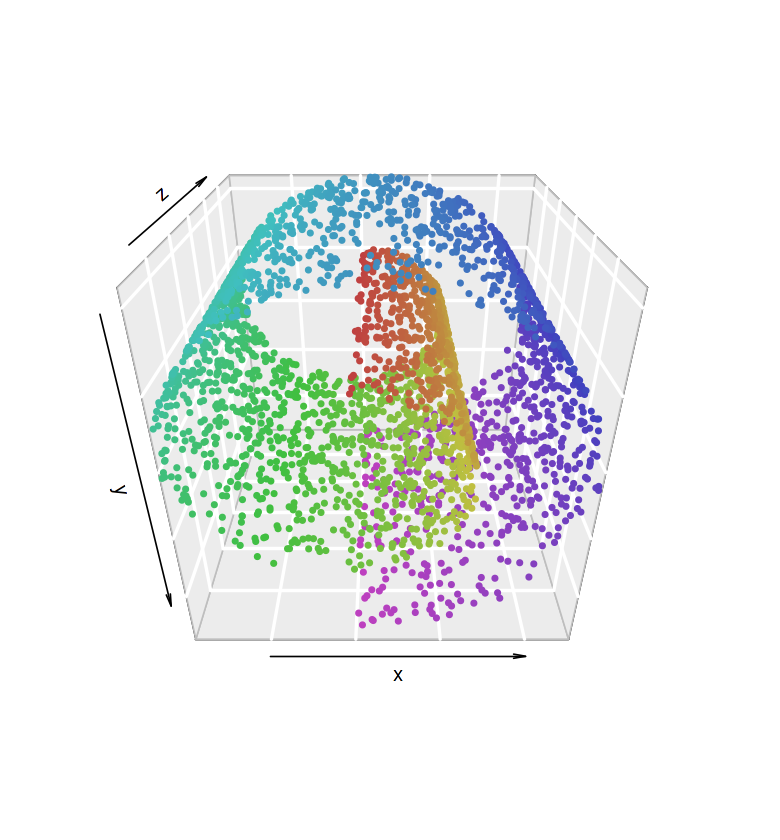

In [74]:
scatter3D(sr3k_30$x, sr3k_30$y, sr3k_30$z, colvar = NULL, col = sr3k_30$color,
          pch = 19, cex = 0.5, theta = 0, phi = -60, bty = "g")

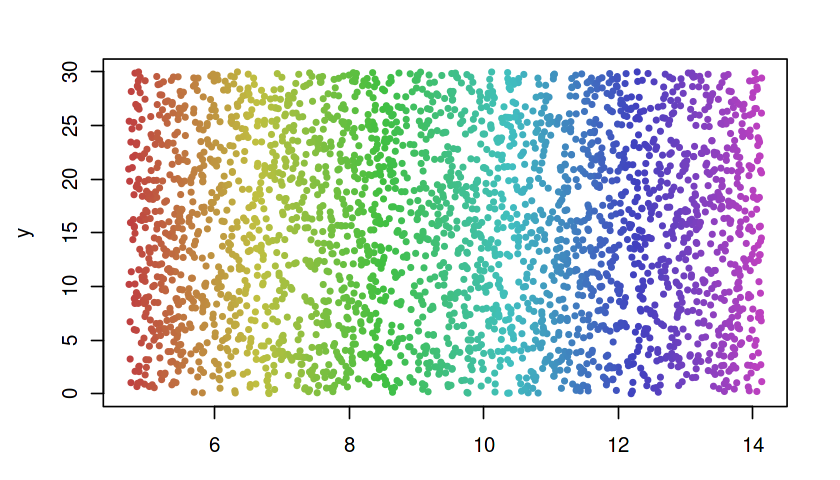

In [92]:
options(repr.plot.width=7, repr.plot.height=4)
scatter2D(sr3k_30$phi, sr3k_30$z, colvar = NULL, col = sr3k_30$color,
          pch = 19, cex = 0.5)

In [94]:
pdf("Swissroll.pdf", width=7, height=7)
scatter3D(sr3k_30$x, sr3k_30$y, sr3k_30$z, colvar = NULL, col = sr3k_30$color,
          pch = 19, cex = 0.5, theta = 0, phi = -60, bty = "g")
dev.off() 

png 
  2

In [93]:
pdf("Swissroll_unfold.pdf", width=7, height=4)
scatter2D(sr3k_30$phi, sr3k_30$z, colvar = NULL, col = sr3k_30$color,
          pch = 19, cex = 0.5)
dev.off() 

png 
  2